# Imports

In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# Functions

In [2]:
def anglewrap(angList):
    # maps an 0 to 360 angle to -180 to +180
    for i in range(len(angList)):
        if (angList[i] > 180):
            angList[i] = angList[i] - 360
    return 

def wrap_to_pi(angle):
    # Better function to wrap angle
    return ((angle + np.pi) % (2 * np.pi)) - np.pi

In [3]:

def import_data(name: str, wrap = True, cleanup = True):
    file = name + ".csv"
    pdoa_data = []
    tdoa_data = []
    rx_true_r = []

    dist_meas = []
    twr_count = []
    dist_true_r = []

    with open(file, "r") as f:
        reader = csv.reader(f)
        for i, line in enumerate(reader):
            linetype = int(line[0])
            if (linetype == 0):
                # rx data, featuring pdoa, tdoa and distance
                pdoa_data += [float(line[1])]
                tdoa_data += [int(line[2])]
                rx_true_r += [float(line[3])]
            
            if (linetype == 1):
                dist_meas += [int(line[5])]
                twr_count += [int(line[6])]
                dist_true_r += [float(line[7])]

            if (linetype == 2):
                print("CIR data")
    
    if (wrap):
        # Wrap angles
        anglewrap(rx_true_r)
        anglewrap(dist_true_r)

    if (cleanup):
        # Remove extreme dist outliers:
        dist_keep_indx = [i > 1000 for i in dist_meas]
        dist_meas_filt = []
        dist_r_filt = []
        twr_count_filt = []

        out_num = 0

        for i in range(len(dist_keep_indx)):
            if dist_keep_indx[i] == True:
                dist_meas_filt += [dist_meas[i]]
                dist_r_filt += [dist_true_r[i]]
                twr_count_filt += [twr_count[i]]
            else:
                out_num += 1

        print("Num of outliers: " + str(out_num))
        # Update values
        dist_meas = dist_meas_filt
        dist_true_r = dist_r_filt
        twr_count = twr_count_filt
    
    return (pdoa_data, tdoa_data, rx_true_r, dist_meas, twr_count, dist_true_r)

# Prepare data

In [4]:
rx_true_r = []
pdoa_data = []
dist_true_r = []
dist_meas = []

# , "m1_to_m2_rot2", "m1_to_m2_rot", "m4_to_m1_rot", "m5_to_m1_rot"

# List of measurements:
files = ["new_rot5m", "m1_to_m2_rot2", "m1_to_m2_rot", "m4_to_m1_rot", "m5_to_m1_rot"]
log_num = len(files)
for log in files:
    temp_pdoa, _, temp_rx_r, temp_dist, _, temp_dist_r = import_data(log, True, False)
    rx_true_r += [temp_rx_r]
    pdoa_data += [temp_pdoa]
    dist_true_r += [temp_dist_r]
    dist_meas += [temp_dist]

# Plot data

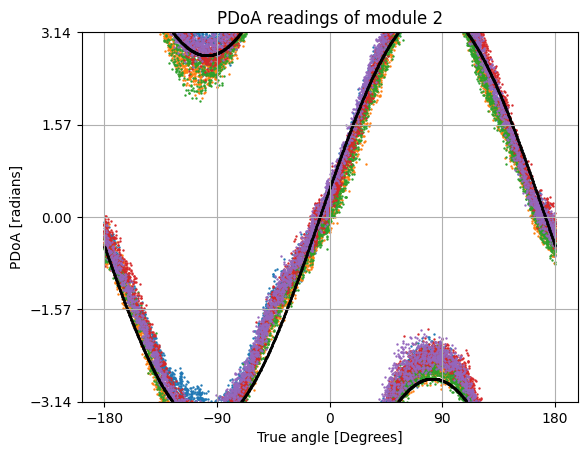

In [ ]:
d = 0.026 # 0.0231      # Distance between antennas
f = 6.4896e9    # frequency
c = 299792458   # speed of light
lam = c/f       # wavelength

pdoa2ang = lambda a : np.arcsin((a*lam)/(2*np.pi*d))
ang2pdoa = lambda a : np.sin(a)*(2*np.pi*d)/(lam)

dummy_pdoa = np.linspace(-np.pi,np.pi,1000)
dummy_ang = np.linspace(-np.pi,np.pi,2000)
ideal_ang = pdoa2ang(dummy_pdoa)*(180/np.pi) # in degrees
ideal_pdoa = wrap_to_pi(ang2pdoa(dummy_ang+8*(np.pi/180)))

plt.figure()
plt.title("PDoA readings of module 2")
for i in range(log_num):
    plt.scatter(rx_true_r[i], pdoa_data[i], s=0.5)
plt.scatter(dummy_ang*(180/np.pi), ideal_pdoa, color='black', s=0.5)
#plt.scatter(ideal_ang, dummy_pdoa, color='black',s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("PDoA [radians]")
plt.xticks([-180, -90, 0, 90, 180])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()



In [6]:
# Piecewise function for PDoA

def pdoa2ang_piece(a):
    # Function for converting pdoa to angle - including all the possible ambiguities
    
    d = 0.027 # 0.0231      # Distance between antennas
    f = 6.4896e9    # frequency
    c = 299792458   # speed of light
    lam = c/f       # wavelength
    ang_offset = -8*(np.pi/180) # calibration angular offset
    pdoa_offset = -10*(np.pi/180) # calibration pdoa offset

    # Apply pdoa offset
    a = wrap_to_pi(a + pdoa_offset)

    # The two thresholds
    rupp = -(2*np.pi*d)/lam + 2*np.pi 
    rlow = (2*np.pi*d)/lam - 2*np.pi 

    ang1 = np.arcsin((a*lam)/(2*np.pi*d))
    
    if a >= rupp:
        ang2 = np.arcsin(((a-2*np.pi)*lam)/(2*np.pi*d)) 
    elif a <= rlow:
        ang2 = np.arcsin(((a+2*np.pi)*lam)/(2*np.pi*d)) 
    else:
        # Simple case of only two ambiguities:
        mang = np.zeros(2)
        mang[0] = wrap_to_pi(ang1 + ang_offset)
        mang[1] = wrap_to_pi(np.pi - ang1 + ang_offset)

        return mang
    # More advanced case of four ambiguities:

    mang = np.zeros(4)
    mang[0] = wrap_to_pi(ang1 + ang_offset)
    mang[1] = wrap_to_pi(ang2 + ang_offset)
    mang[2] = wrap_to_pi(np.pi - ang1 + ang_offset)
    mang[3] = wrap_to_pi(np.pi - ang2 + ang_offset)

    return mang

def gen_adv_amb(a):
    
    d = 0.027 # 0.0231      # Distance between antennas
    f = 6.4896e9    # frequency
    c = 299792458   # speed of light
    lam = c/f       # wavelength
    
    pdoa = wrap_to_pi(np.sin(a)*(2*np.pi*d)/(lam)) # First generate the equivalent pdoa
    mang = pdoa2ang_piece(pdoa) # Then all the ambiguities
    return mang

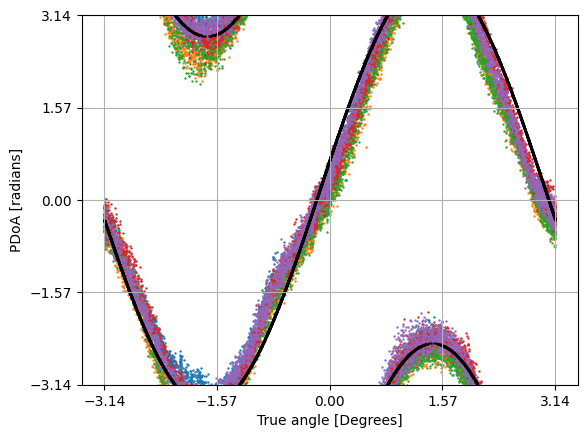

In [7]:
# Test piecewise function
dummy_pdoa = np.linspace(-np.pi,np.pi,2000)

pdoa2plot = np.empty([0])
angle2plot = np.empty([0])

for pdoa in dummy_pdoa:
    temp = pdoa2ang_piece(pdoa)
    
    angle2plot = np.append(angle2plot, temp)
    pdoa2plot = np.append(pdoa2plot, np.ones_like(temp)*pdoa)


# And then attempt to plot it:

plt.figure()
for i in range(log_num):
    plt.scatter(np.array(rx_true_r[i])*(np.pi/180), pdoa_data[i], s=0.5)
plt.scatter(angle2plot, pdoa2plot, s=0.5, color='black')
plt.xlabel("True angle [Degrees]")
plt.ylabel("PDoA [radians]")
plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()

# Try to test the angle2multiamb function:
#mang= gen_adv_amb(0.5)
#pdoa = np.ones_like(mang)*0

#plt.scatter(mang, pdoa, color='red')



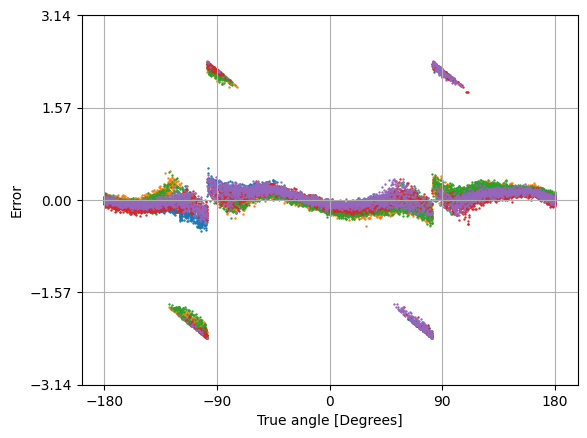

In [8]:
# Calculate angle error

# Initialize lists

ang_errors = []

# Find errors
for i in range(log_num):
    len_pdoa = len(pdoa_data[i])

    error = np.empty([0])

    for j in range(len_pdoa):
        mang = pdoa2ang_piece(pdoa_data[i][j])
        true_val = np.ones_like(mang)*rx_true_r[i][j]*(np.pi/180)
        diff = wrap_to_pi(mang - true_val)
        min_idx = np.argmin(np.abs(diff))
        # Append error
        error = np.append(error, diff[min_idx])
    
    ang_errors += [error]

# Then plot them:

for i in range(log_num):
    plt.scatter(rx_true_r[i], ang_errors[i], s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("Error")
plt.xticks([-180, -90, 0, 90, 180])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()

In [9]:
# Find the standard deviation:
cat_ang_error = np.empty([0])
for i in range(log_num):
    cat_ang_error = np.append(cat_ang_error, ang_errors[i])

error_thres = 1.5
filt_ang_error = cat_ang_error[np.abs(cat_ang_error) <= error_thres]

ang_mean = np.mean(filt_ang_error)
ang_var = np.var(filt_ang_error)

print("Mean: " + str(ang_mean))
print("Variance: " + str(ang_var))



Mean: 0.01141135534336643
Variance: 0.017693119882063613


# Actually do it properly

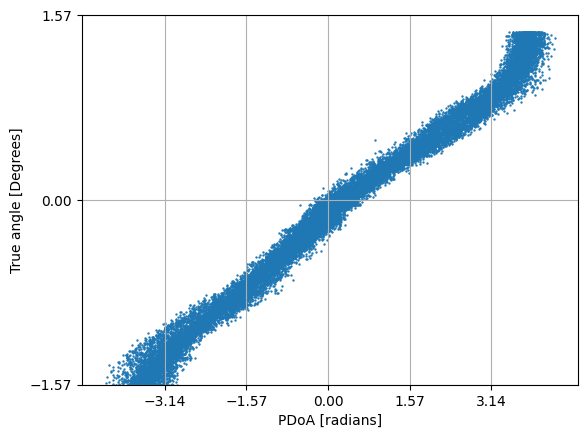

In [10]:
# alter data, to remove ambiguities:
# Mirror the data around 90 degrees axis
r_altered = []
offset = 8*(np.pi/180)
low_mirror = -np.pi/2-offset
high_mirror = np.pi/2-offset

for i in range(log_num):
    temp = np.array(rx_true_r[i])*(np.pi/180)
    temp[temp < low_mirror] = wrap_to_pi(np.pi - temp[temp < low_mirror]) - 2*offset
    temp[temp > high_mirror] = wrap_to_pi(np.pi - temp[temp > high_mirror]) - 2*offset
    r_altered += [temp]

# Move the blobs down, to kill the phase wrapping:

pdoa_altered = []

for i in range(log_num):
    temp = np.array(pdoa_data[i])
    indx1 = (temp > np.pi/2) & (r_altered[i] < 0)
    indx2 = (temp < -np.pi/2) & (r_altered[i] > 0)
    
    temp[indx1] -= 2*np.pi
    temp[indx2] += 2*np.pi

    pdoa_altered += [temp]
    
# Combine into one big numpy array
pdoa_altered2 = np.concatenate(pdoa_altered)
r_altered2 = np.concatenate(r_altered)

plt.figure()
plt.scatter(pdoa_altered2, r_altered2, s=0.5)
plt.ylabel("True angle [Degrees]")
plt.xlabel("PDoA [radians]")
plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi/2, np.pi/2])
plt.grid()



C:\Users\marcu\AppData\Local\Temp\ipykernel_11196\323169364.py:10: RuntimeWarning: invalid value encountered in arcsin
  return np.arcsin(arg)+aoff


R-squared: 0.8706
R-squared: 0.9848
R-squared: 0.9873
[ 0.36288748 -0.16759607]


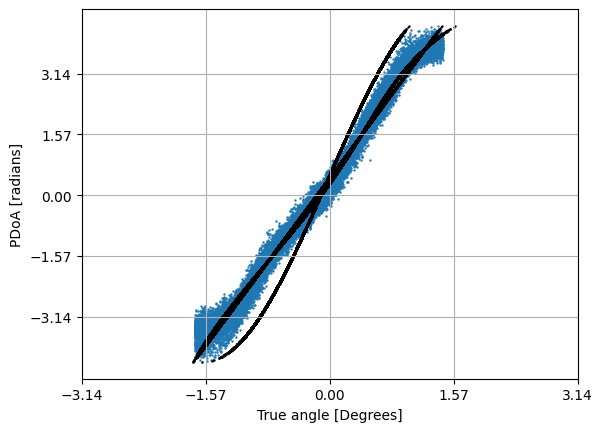

In [11]:
# Perform fitting on the altered data

def pdoa2fit(x, d, poff, aoff):
    f = 6.4896e9    # frequency
    c = 299792458   # speed of light
    lam = c/f       # wavelength

    arg = ((x+poff)*lam)/(2*np.pi*d)

    return np.arcsin(arg)+aoff

def pdoa2linear(x, a, b):
    return a*(x) + b

initial_guess_sin = [0.1, 0, 0]
initial_guess_lin = [1.0, 0]

params_lin, covariance_lin = curve_fit(pdoa2linear, pdoa_altered2, r_altered2, p0=initial_guess_lin)
lin_fit = pdoa2linear(pdoa_altered2, *params_lin)
params_sin, covariance_sin = curve_fit(pdoa2fit, pdoa_altered2, r_altered2, p0=initial_guess_sin)
sin_fit = pdoa2fit(pdoa_altered2, *params_sin)
params_poly = np.polyfit(pdoa_altered2, r_altered2, 5)
poly_fit = np.polyval(params_poly, pdoa_altered2)

r2_sin = r2_score(r_altered2, sin_fit)
print(f"R-squared: {r2_sin:.4f}")

r2_lin = r2_score(r_altered2, lin_fit)
print(f"R-squared: {r2_lin:.4f}")

r2_poly = r2_score(r_altered2, poly_fit)
print(f"R-squared: {r2_poly:.4f}")

plt.figure()
plt.scatter(r_altered2, pdoa_altered2, s=0.5)
plt.scatter(lin_fit, pdoa_altered2, color='black', s=0.5)
plt.scatter(sin_fit, pdoa_altered2, color='black', s=0.5)
plt.scatter(poly_fit, pdoa_altered2, color='black', s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("PDoA [radians]")
plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.grid()

print(params_lin)


In [18]:
# New picewise function:

def pdoa2ang_piece(x):
    # Function for converting pdoa to angle - including all the possible ambiguities
    
    a = 0.36288748
    b = -0.16759607
    
    # The two thresholds
    rupp = (-np.pi/2)/a + 2*np.pi
    rlow = (np.pi/2)/a - 2*np.pi

    ang1 = a*(x)
    
    if x >= rupp:
        ang2 = a*(x-2*np.pi)
    elif x <= rlow:
        ang2 = a*(x+2*np.pi)
    else:
        # Simple case of only two ambiguities:
        mang = np.zeros(2)
        mang[0] = wrap_to_pi(ang1 + b)
        mang[1] = wrap_to_pi(np.pi - ang1 + b)

        return mang
    # More advanced case of four ambiguities:

    mang = np.zeros(4)
    mang[0] = wrap_to_pi(ang1 + b)
    mang[1] = wrap_to_pi(ang2 + b)
    mang[2] = wrap_to_pi(np.pi - ang1 + b)
    mang[3] = wrap_to_pi(np.pi - ang2 + b)

    return mang

def gen_adv_amb(x):
    
    a = 0.36288748
    b = -0.16759607
    
    pdoa = wrap_to_pi((x-b)/a) # First generate the equivalent pdoa
    mang = pdoa2ang_piece(pdoa) # Then all the ambiguities
    return mang

2.416421271134869


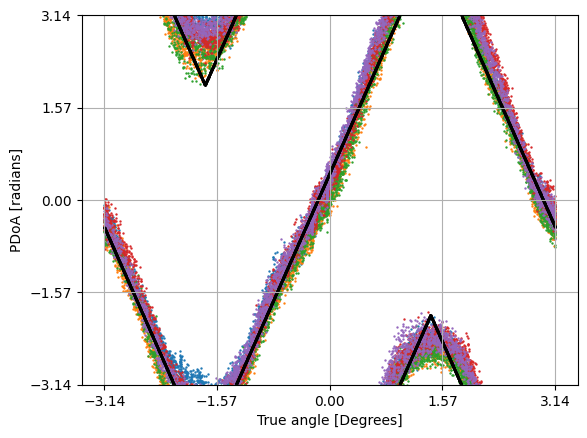

In [ ]:
# Test piecewise function
dummy_pdoa = np.linspace(-np.pi,np.pi,2000)
dummy_ang = np.linspace(-2*np.pi, 2*np.pi, 2000)

ang2pdoa = lambda x : wrap_to_pi((x-(-0.16759607))/0.36288748)

pdoa2plot = np.empty([0])
angle2plot = np.empty([0])

for pdoa in dummy_pdoa:
    temp = pdoa2ang_piece(pdoa)
    
    angle2plot = np.append(angle2plot, temp)
    pdoa2plot = np.append(pdoa2plot, np.ones_like(temp)*pdoa)


# And then attempt to plot it:

plt.figure()
for i in range(log_num):
    plt.scatter(np.array(rx_true_r[i])*(np.pi/180), pdoa_data[i], s=0.5)
plt.scatter(angle2plot, pdoa2plot, s=0.5, color='black')
#plt.scatter(dummy_ang, ang2pdoa(dummy_ang), s=0.5, color='black')
plt.xlabel("True angle [Degrees]")
plt.ylabel("PDoA [radians]")
plt.xticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()

print(ang2pdoa(-np.pi/2))

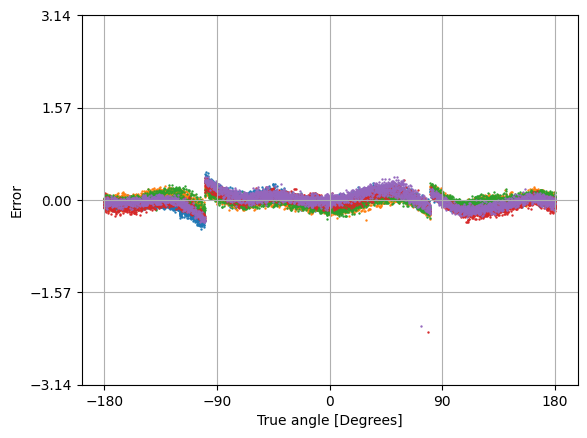

In [20]:
# Calculate angle error

# Initialize lists

ang_errors = []

# Find errors
for i in range(log_num):
    len_pdoa = len(pdoa_data[i])

    error = np.empty([0])

    for j in range(len_pdoa):
        mang = pdoa2ang_piece(pdoa_data[i][j])
        true_val = np.ones_like(mang)*rx_true_r[i][j]*(np.pi/180)
        diff = wrap_to_pi(mang - true_val)
        min_idx = np.argmin(np.abs(diff))
        # Append error
        error = np.append(error, diff[min_idx])
    
    ang_errors += [error]

# Then plot them:

for i in range(log_num):
    plt.scatter(rx_true_r[i], ang_errors[i], s=0.5)
plt.xlabel("True angle [Degrees]")
plt.ylabel("Error")
plt.xticks([-180, -90, 0, 90, 180])
plt.yticks([-3.14, -3.14/2, 0, 3.14/2, 3.14])
plt.ylim([-np.pi, np.pi])
plt.grid()

In [21]:
# Find the standard deviation:
cat_ang_error = np.empty([0])
for i in range(log_num):
    cat_ang_error = np.append(cat_ang_error, ang_errors[i])

error_thres = 1.5
filt_ang_error = cat_ang_error[np.abs(cat_ang_error) <= error_thres]

ang_mean = np.mean(filt_ang_error)
ang_var = np.var(filt_ang_error)

print("Mean: " + str(ang_mean))
print("Variance: " + str(ang_var))

Mean: -0.012385902726207834
Variance: 0.01154411268306648
